**Problem**
- E-commerce dealing with online transactions naturally be exposed to fraudent activities.(stolen credit cards, money laundary etc)
- Company XYZ sell handmade clothes online.
- The compnay wants a model that predict fraud of user first online transaction.

**Goal**
- Build a model to predict whether the user has a high probablity of using the site to perform some illegal activities or not.

**Tasks**
- determine user country based on her numerical IP address
- Build a model to predict whether an activity is fraudent or not. Explain how different assumptions about the cost of FP vs FN impact the model.
- From user perspective, interpret how the model make predictions. What kind of users are more likely to be considered with high risk? What are their characteristics?
- If the model can be used in real-time and live predict fruad, from product perspective, how would you use the model? What kind of different user experience would you build based on the model output?

**How I did it**
- Task 1: write a binary search function and applied on the dataframe
- Task 2: used logistic regression and confusion matrix
- Task 3: intepret features by partial plots and visualizing tree main splits
- Task 4: product sense on how to combine model with real world goals

**Conclusions**
- Fraudent activities can be related to the time difference between signup and purchase, if a device is used by multiple users, or if an ip is related to multiple users.
- For this imbalanced dataset, oversampling the minority and building a random forest model gives out promising result.
- For the fraud and risk context, the ultimate goal is really important guiding us to choose model or hyperparameters (e.g. FP or FN, which one is more related to our goal)
- For the real-time product, we consider additional verification and manually review depend on the risk score (which is the probability of fraud in this case).

In [1]:
# libraries and plots settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy import stats
import statsmodels.api as sm

# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 60}
# sns.set_context("poster")

In [3]:
df_fraud = pd.read_csv('./Fraud_Data.csv')
df_ip_country = pd.read_csv('./IpAddress_to_Country.csv')

In [4]:
df_fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [5]:
df_ip_country.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


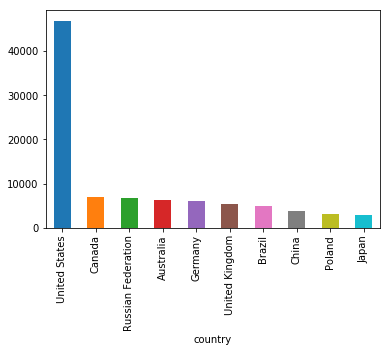

In [6]:
df_ip_country.groupby(['country']).size().sort_values(ascending = False).head(10).plot.bar()

In [7]:
df_ip_country[df_ip_country['country'] == 'United States'].sort_values(by=['lower_bound_ip_address', 'upper_bound_ip_address']).head()

,lower_bound_ip_address,upper_bound_ip_address,country
145,50331648.0,67108863,United States
146,67108864.0,83886079,United States
667,93894656.0,93896703,United States
911,100663296.0,117440511,United States
912,117440512.0,134217727,United States


## check data

In [8]:
# missing values
print(100*df_fraud.isna().sum()/len(df_fraud))
print(100*df_ip_country.isna().sum()/len(df_ip_country))

user_id           0.0
signup_time       0.0
purchase_time     0.0
purchase_value    0.0
device_id         0.0
source            0.0
browser           0.0
sex               0.0
age               0.0
ip_address        0.0
class             0.0
dtype: float64
lower_bound_ip_address    0.0
upper_bound_ip_address    0.0
country                   0.0
dtype: float64


In [9]:
print(len(df_fraud))
print(len(df_ip_country))

151112
138846


## Task 1: Determine user country based on her numercial IP address

In [10]:
df_ip_country_sort = df_ip_country.sort_values(by=['lower_bound_ip_address', 'upper_bound_ip_address'])
df_ip_country_sort.head()
#the orginial dataset seems to be already sorted by lower and then upper ip
df_ip_country_sort.iloc[[1]].lower_bound_ip_address

1    16777472.0
Name: lower_bound_ip_address, dtype: float64

In [11]:
def user_country(ip_address, df):
    #binary search to determine user country
    start, end = 0, len(df)-1
    while start + 1 < end:
        mid = (start + end)//2
        if df.loc[mid, 'lower_bound_ip_address'] == ip_address:
            return df_ip_country.loc[mid, 'country']
        elif df.loc[mid, 'lower_bound_ip_address'] < ip_address:
            start = mid
        else:
            end = mid
    if df.loc[end, 'lower_bound_ip_address'] <= ip_address:
        return df_ip_country.loc[end, 'country']
    elif df.loc[start, 'lower_bound_ip_address'] <= ip_address:
        return df_ip_country.loc[start, 'country']
    
   

In [12]:
df = df_fraud.copy()

In [13]:
#print(user_country(7.327584e+08, df_ip_country_sort))
df['country'] = df['ip_address'].apply(lambda x: user_country(x, df_ip_country))

In [14]:
100*df.isna().sum()/len(df)

user_id           0.000000
signup_time       0.000000
purchase_time     0.000000
purchase_value    0.000000
device_id         0.000000
source            0.000000
browser           0.000000
sex               0.000000
age               0.000000
ip_address        0.000000
class             0.000000
country           0.419556
dtype: float64

why there is 42% missing value in the country column? Is there anything wrong with the function that assign the country according to ip address? since it only considered the lower boundary ip for the binary classification.

In [15]:
df = df.fillna('Not Found')
if len(df['user_id'].unique()) == len(df): # if there is no duplicate in the user_id
    df = df.drop(columns = ['user_id'])

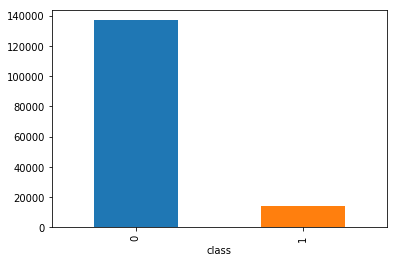

In [16]:
df.groupby('class').size().plot.bar()

The dataset is imbalanced. The fraudent class is minority. Building models on the orignal dataset and then oversample the minority to see any improvement.

Before building the model, let's take a look and engineer some features first. If brainstroming on possible signals of fraudent activities, possible variables are:
- **time interval** between signup time and first pruchase time (deduction)
- if many different users are using the **same devices** (indicator variable on devices that being performed by many different users, or a variable that show the count of multiple users)
- if many different users are using the **same ip address** (indicator variable on same ip address by different users, or a count show the number of multiple users)
- if the transactions occured at **normal human activities hours** (e.g. people rarely make normal transactions during 2am-4am without website campinage and transactions may also not frequent during busy working hours)

In [17]:
df.head(2)

,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States


In [18]:
df['purchase_signup_diff'] = (pd.to_datetime(df['purchase_time'])-  pd.to_datetime(df['signup_time'])).astype('timedelta64[s]')

In [19]:
df.sort_values('purchase_signup_diff').head(5)

,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,purchase_signup_diff
128682,2015-01-11 19:11:15,2015-01-11 19:11:16,13,XGLHXETOONGJR,SEO,FireFox,F,26,1.080791e+09,1,United States,1.0
7372,2015-01-09 19:19:08,2015-01-09 19:19:09,62,IVCMLWTZIZKBS,Ads,Chrome,F,24,1.804099e+09,1,United States,1.0
92770,2015-01-03 05:31:38,2015-01-03 05:31:39,27,VLNELJEFKHYNR,SEO,FireFox,M,29,2.456795e+09,1,United States,1.0
15041,2015-01-12 03:42:47,2015-01-12 03:42:48,69,HCYSLYNRFLAXU,Ads,Chrome,F,34,1.599329e+09,1,Ireland,1.0
48807,2015-01-03 10:15:59,2015-01-03 10:16:00,9,STJGIGUAWTUVX,Ads,IE,F,35,2.893227e+09,1,United States,1.0


It is very obvious that 1s purchase behavior after signup highly correlate with fraudent activities, which make sense since normal human won't perform a such fast action. It is more like a behavior of a bot. 

let's plot fraudent-count vs time-interval distribution.

In [20]:
def check_dist(dimension, dataframe):
    fig, ax = plt.subplots(figsize=(10,7))
    normal_group = dataframe[dimension].loc[dataframe['class']==0]
    fraud_group = dataframe[dimension].loc[dataframe['class']==1]
    
    sns.distplot(normal_group, hist=True ,ax = ax)
    sns.distplot(fraud_group, hist=True, ax = ax)
    plt.tight_layout()
    plt.ylabel("Prob")


/Users/zhili/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


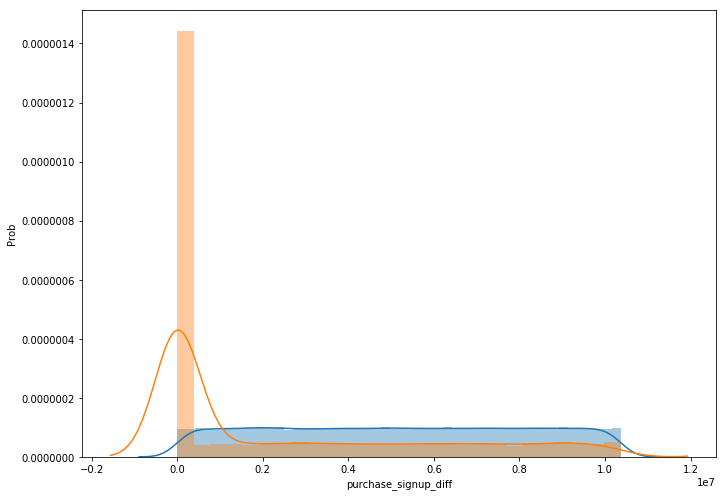

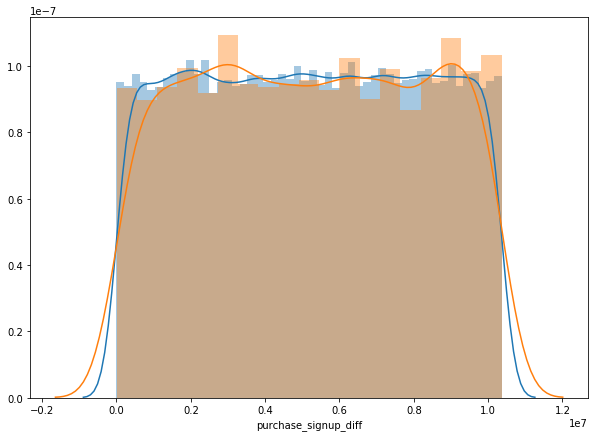

In [21]:
check_dist('purchase_signup_diff', df)


fig, ax = plt.subplots(figsize=(10,7))
normal_group_rm1s = df['purchase_signup_diff'].loc[(df['class']==0) & (df['purchase_signup_diff']!= 1.0)]
fraud_group_rm1s = df['purchase_signup_diff'].loc[df['class']==1 & (df['purchase_signup_diff']!= 1.0)]
    
sns.distplot(normal_group_rm1s, hist=True ,ax = ax)
sns.distplot(fraud_group_rm1s, hist=True, ax = ax)

Fraud activities largely occur at 1s. For fraudent activities that happen that purchase time is more than 1s after signup time, the distributions of fraud and normal do not differ too much.

Next, let's flag the rows that either device or ip address are linked to multiple users.

In [22]:
df_device_usercount = pd.DataFrame(df.groupby(['device_id']).size().sort_values(ascending = False))
df_device_usercount = df_device_usercount.reset_index()
df_device_usercount = df_device_usercount.rename(columns={"device_id": "device_id", 0: "device_count"})
df_device_usercount.head()

,device_id,device_count
0,KIPFSCNUGOLDP,20
1,ITUMJCKWEYNDD,20
2,CQTUVBYIWWWBC,20
3,NGQCKIADMZORL,20
4,EQYVNEGOFLAWK,20


In [23]:
df_ip_usercount = pd.DataFrame(df.groupby(['ip_address']).size().sort_values(ascending = False))
df_ip_usercount = df_ip_usercount.reset_index()
df_ip_usercount = df_ip_usercount.rename(columns={'ip_address': "ip_address", 0: "ip_count"})
df_ip_usercount.head()

,ip_address,ip_count
0,1.502818e+09,20
1,5.760609e+08,20
2,3.874758e+09,20
3,2.050964e+09,20
4,3.484934e+08,19


In [24]:
df = pd.merge(df, df_device_usercount, how = 'inner', on = 'device_id')
df = pd.merge(df, df_ip_usercount, how = 'inner', on = 'ip_address')
df.head()

,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,purchase_signup_diff,device_count,ip_count
0,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0,1,1
1,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0,1,1
2,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1.0,12,12
3,2015-01-01 18:52:41,2015-01-01 18:52:42,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1.0,12,12
4,2015-01-01 18:52:40,2015-01-01 18:52:41,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1.0,12,12


let's take a look how fraud is related to the device_count and ip_count. 

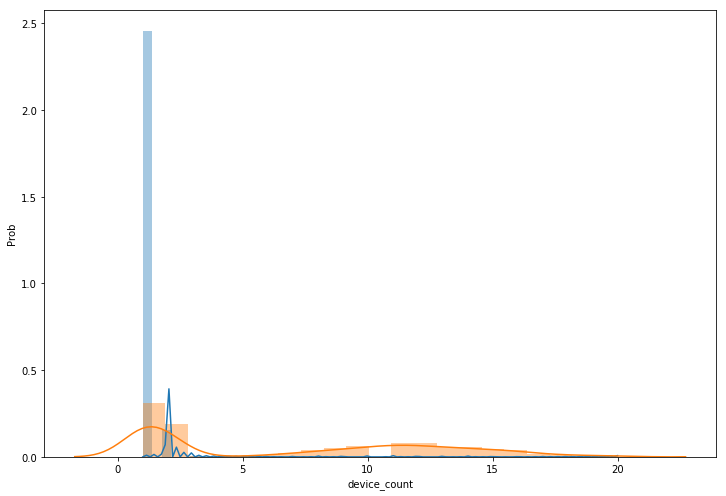

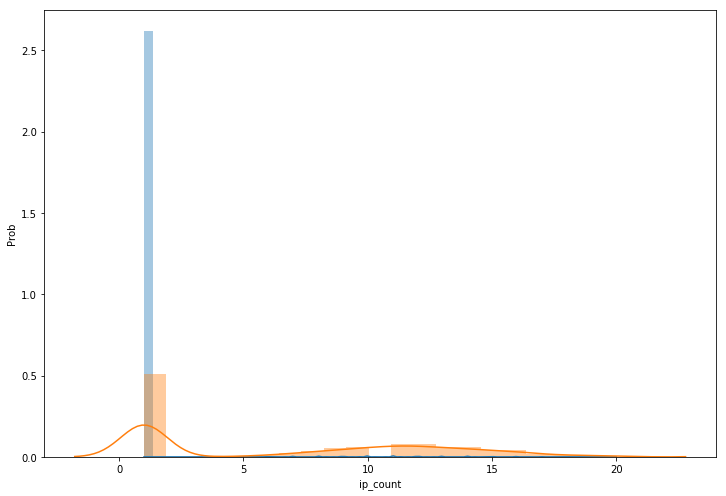

In [25]:
check_dist('device_count', df)
check_dist('ip_count', df)

The normal transactions usually corresponding to one user use one device in one ip_address. Multiple users using one ip address or one device may flag fraudent activities. This matches our previous intuition.

Now let's see fraudent counts along the time. Also translate time into week, hour day.

In [26]:
df['signup_time'] = pd.to_datetime(df['signup_time'])
df['purchase_time'] = pd.to_datetime(df['purchase_time'])
#df.sort_values(by=['signup_time'], inplace=True, ascending=False)
df_signup = df.set_index('signup_time')['class']
#df_purchase = df.set_index('purchase_time')['class']

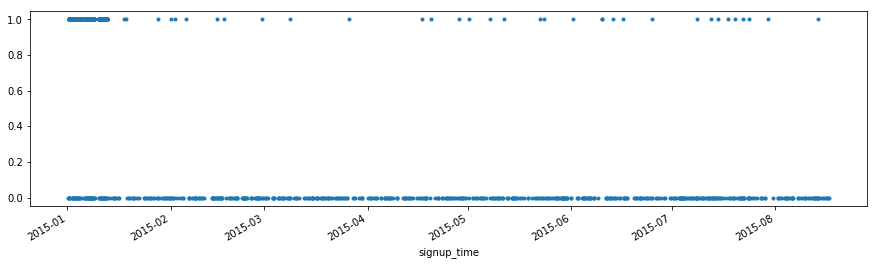

In [27]:
df_signup.head(1000).plot(y=["class"], figsize=(15,4), style='.')
#df_purchase.head(500).plot(y=["class"], figsize=(15,4), style='.')

In [28]:
def datetime_transform(dataframe, column):
    dataframe[column] = pd.to_datetime(dataframe[column])
    dataframe[column+"_year"] = pd.to_datetime(dataframe[column]).dt.year
    dataframe[column+"_month"] = pd.to_datetime(dataframe[column]).dt.month
    dataframe[column+"_day"] = pd.to_datetime(dataframe[column]).dt.day
    dataframe[column+"_hour"] = pd.to_datetime(dataframe[column]).dt.hour
    dataframe[column+"_dayofweek"] = pd.to_datetime(dataframe[column]).dt.dayofweek
    #return dataframe

In [29]:
datetime_transform(df, "signup_time")
datetime_transform(df, "purchase_time")

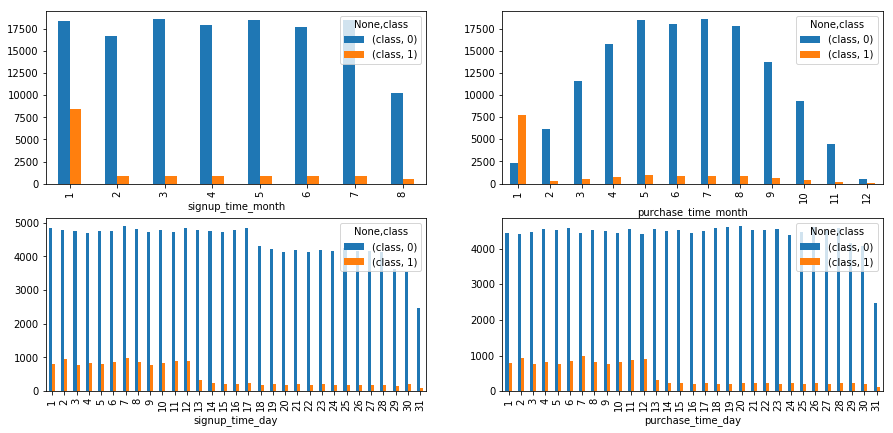

In [48]:
fig, axes = plt.subplots(figsize=(15,7), nrows=2, ncols=2)
#df1.plot(ax=axes[0,0])
df.groupby(['signup_time_month', 'class']).agg({'class': np.size}).unstack().plot.bar(ax=axes[0,0])
#df2.plot(ax=axes[0,1])
df.groupby(['purchase_time_month', 'class']).agg({'class': np.size}).unstack().plot.bar(ax=axes[0,1])
df.groupby(['signup_time_day', 'class']).agg({'class': np.size}).unstack().plot.bar(ax=axes[1,0])
df.groupby(['purchase_time_day', 'class']).agg({'class': np.size}).unstack().plot.bar(ax=axes[1,1])


January is the month with the most fraudent activities. fraudent activities seems to happend near the early days of the month.

## Task 2: build a model to predict whether an activity is fraudent. Explain FP, FN trade-off.

In [28]:
# load libraries
from sklearn.linear_model import LogisticRegression
from sklearn import metrics 
from sklearn.model_selection import  KFold, train_test_split, cross_val_score 
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, recall_score, \
precision_score, roc_auc_score, classification_report, f1_score

In [29]:
df.head(2)

,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,purchase_signup_diff,device_count,ip_count
0,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0,1,1
1,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0,1,1


In [30]:
y = df['class']
X = df.drop(columns = ['class','device_id', 'signup_time', 'purchase_time', 'ip_address'])
X=pd.get_dummies(X, drop_first=True)

X_tt, X_holdout, y_tt, y_holdout = train_test_split(X, y, test_size=0.33)

In [31]:
X.head(2)

,purchase_value,age,purchase_signup_diff,device_count,ip_count,source_Direct,source_SEO,browser_FireFox,browser_IE,browser_Opera,...,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Venezuela,country_Viet Nam,country_Virgin Islands (U.S.),country_Yemen,country_Zambia,country_Zimbabwe
0,34,39,4506682.0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,16,53,17944.0,1,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


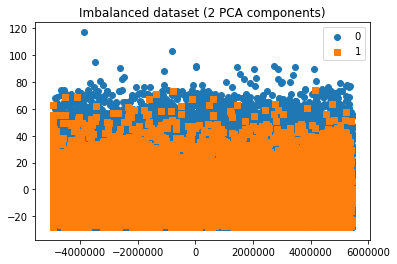

In [32]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
plot_X = pca.fit_transform(X)

plot_2d_space(plot_X, y, 'Imbalanced dataset (2 PCA components)')

It seems the data is not linearly separable. It is not guaranteed logit will show good result. but let's try it first.

In [33]:
LR = LogisticRegression(penalty='l1',solver='liblinear')
scores = cross_validate(LR,X_tt,y_tt,cv=5,scoring='recall')
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: {'fit_time': array([1.22803688, 0.45364809, 0.61037493, 0.83429193, 1.17402267]), 'score_time': array([0.03688407, 0.03873324, 0.03823996, 0.03713989, 0.03798318]), 'test_score': array([0.53031915, 0.5356383 , 0.51968085, 0.51170213, 0.52553191])}


In [34]:
LR.fit(X_tt,y_tt)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

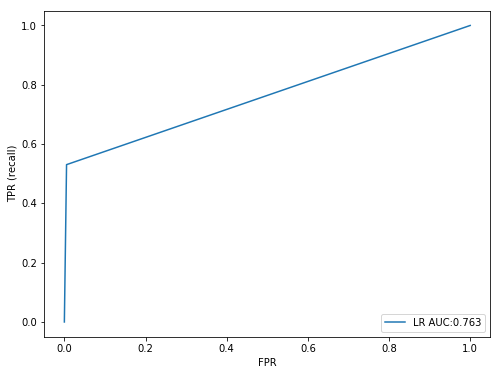

In [35]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

plt.figure(figsize=(8, 6))
fpr, tpr, thresholds = roc_curve(y_holdout, LR.predict(X_holdout))
auc = roc_auc_score(y_holdout, LR.predict(X_holdout))
plt.plot(fpr, tpr, label='LR' +" AUC:{:.3f}".format(auc))
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.legend(loc=4)
close_zero = np.argmin(np.abs(thresholds))

In [36]:
print(classification_report(y_holdout,LR.predict(X_holdout)))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     45116
           1       0.91      0.53      0.67      4751

    accuracy                           0.95     49867
   macro avg       0.93      0.76      0.82     49867
weighted avg       0.95      0.95      0.94     49867



Logistic Regression gives out recall that is slight better than random guess. I would not say it is a good model, especially currently the data is very imbalanced that I didn't do any oversampling yet.

In [37]:
from sklearn.ensemble import GradientBoostingClassifier 
GBoost = GradientBoostingClassifier()
scores = cross_validate(GBoost,X_tt,y_tt,cv=5,scoring='recall')
GBoost.fit(X_tt,y_tt)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [38]:
print(classification_report(y_holdout,GBoost.predict(X_holdout)))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     45116
           1       1.00      0.54      0.70      4751

    accuracy                           0.96     49867
   macro avg       0.98      0.77      0.84     49867
weighted avg       0.96      0.96      0.95     49867



Gradient boosting gives much higher recall on largely imbalanced dataset without resampling technique. 

## Oversample the minority

/Users/zhili/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


122810 new random picked points


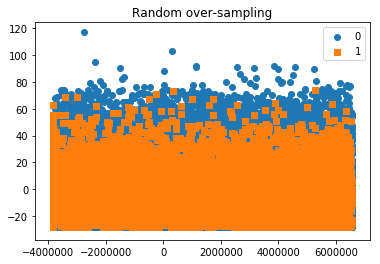

In [39]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X, y)

print(X_ros.shape[0] - X.shape[0], 'new random picked points')

plot_2d_space(pca.fit_transform(X_ros), y_ros, 'Random over-sampling')

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size=0.33)
#LR = LogisticRegression(penalty='l1',solver='liblinear')
#scores = cross_validate(LR,X_ros,y_ros,cv=5,scoring='recall')
LR.fit(X_train,y_train)
print(classification_report(y_holdout,LR.predict(X_holdout)))


              precision    recall  f1-score   support

           0       0.97      0.93      0.95     45116
           1       0.53      0.73      0.61      4751

    accuracy                           0.91     49867
   macro avg       0.75      0.83      0.78     49867
weighted avg       0.93      0.91      0.92     49867



Recall performance largely improved after oversampling and building the model.

In [41]:
# ROC curve
# plt.figure(figsize=(8, 6))
# fpr, tpr, thresholds = roc_curve(y_holdout, LR.predict(X_holdout))
# auc = roc_auc_score(y_holdout, LR.predict(X_holdout))
# plt.plot(fpr, tpr, label='LR' +" AUC:{:.3f}".format(auc))
# plt.xlabel("FPR")
# plt.ylabel("TPR (recall)")
# plt.legend(loc=4)
# close_zero = np.argmin(np.abs(thresholds))

## Random Forest and gradient boosting after oversampling the data

In [42]:
from sklearn.ensemble import RandomForestClassifier as RF
RF = RF()
scores = cross_validate(RF,X_train,y_train,cv=5,scoring='recall')
RF.fit(X_train,y_train)
print(classification_report(y_holdout,RF.predict(X_holdout)))

/Users/zhili/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/zhili/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/zhili/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/zhili/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/zhili/anaconda3/lib/python3.7/site-pa

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     45116
           1       0.94      1.00      0.97      4751

    accuracy                           0.99     49867
   macro avg       0.97      1.00      0.98     49867
weighted avg       0.99      0.99      0.99     49867



Random Forest seems to performing really good on testing set by training on oversampled balanced dataset.

In [43]:
# scores = cross_validate(GBoost,X_train,y_train,cv=5,scoring='recall')
# GBoost.fit(X_train,y_train)
# print(classification_report(y_holdout,GBoost.predict(X_holdout)))

Interpretation of FP and FN tradeoffs.
- ROC curve: TPR(recall or TP/P = TP/(TP+FN)) vs FPR (FP/N = FP/(FP + TN))
- For a given ROC curve, if we care about minimizing false positive, meaning we really care about normal users, we would need to adjust threshold that gives as **small FPR but high TPR** as possible. 
Precision = TP/(TP + FP), minimizing FP and care normal users meaning high precision.

- For a given ROC curve, if we care about minimizing false negative, meaning we really want to capture fraud as many as possible, then we will have to **decrease the threshold** below 0.5.
Recall = TP/(TP+FN) is also TPR, we want maximize recall or TPR.

In many practical ML applications, there is no reason to use default 0.5 cut-off value.

## Characters of fraudent activities

In [44]:
importances = RF.feature_importances_

In [45]:
feature_list = X.columns
std = np.std([tree.feature_importances_ for tree in RF.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, feature_list[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature purchase_signup_diff (0.278408)
2. feature device_count (0.263017)
3. feature purchase_value (0.134156)
4. feature age (0.112941)
5. feature ip_count (0.092145)
6. feature sex_M (0.011357)
7. feature source_SEO (0.009163)
8. feature browser_IE (0.008859)
9. feature browser_FireFox (0.008176)
10. feature source_Direct (0.006893)
11. feature browser_Safari (0.006208)
12. feature country_United States (0.004035)
13. feature country_China (0.003708)
14. feature country_Australia (0.003158)
15. feature country_Japan (0.003015)
16. feature browser_Opera (0.002954)
17. feature country_Korea Republic of (0.002339)
18. feature country_United Kingdom (0.002112)
19. feature country_France (0.002022)
20. feature country_Brazil (0.001968)
21. feature country_Canada (0.001937)
22. feature country_Italy (0.001766)
23. feature country_Germany (0.001710)
24. feature country_Netherlands (0.001696)
25. feature country_Russian Federation (0.001561)
26. feature country_Taiwan; R

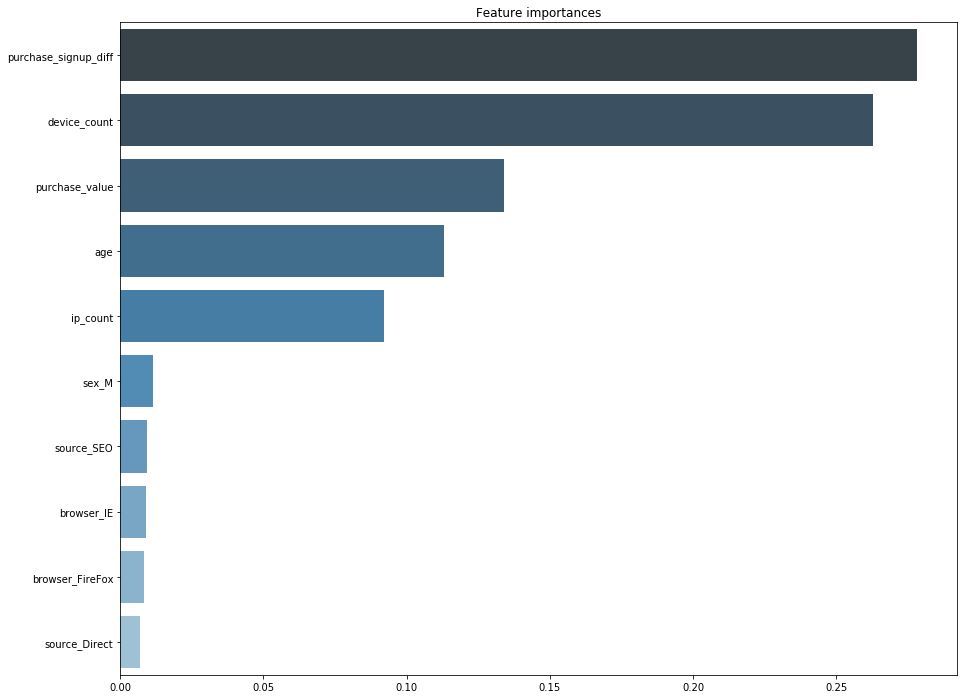

In [46]:
## plot feature importances
feature_names = X.columns 

indices = np.argsort(importances)[::-1]
top_k = 10
new_indices = indices[:top_k]
features = feature_names[indices[:top_k]]


# Plot the feature importances of the forest
f, ax = plt.subplots(figsize=(15, 12))
#plt.figure(figsize=(15, 12))
plt.title("Feature importances")
#sns.set_color_codes("pastel")
sns.set_context("poster")

data_features = pd.DataFrame(list(zip(features, importances[new_indices])), columns = ['topk', 'importances'])
data_feature = data_features.sort_values("importances", ascending=False)
sns.barplot(y = 'topk', x ='importances',data = data_feature, color="b", ci = 'sd',  palette="Blues_d")



#ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set( ylabel="", xlabel="")
# sns.despine(left=True, bottom=True)
ax.grid(False)

we can see that the top features associated with fraud are **purchase_signup_diff, device_count, ip_count, purchase_value, age, Male, SEO, IE, safari, firefox**. The first 3 features are engineered features.

Next, we want to further interpret the model, that is understand if the features gives positive or negative influence on fraud probabilities. We plot:
- partial dependence plot of major variables
- build a simple and small tree to look at the main splits

In [ ]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence

features = features = [0, 1, (0, 1)]
plot_partial_dependence(RF, X, features, n_jobs=3, grid_resolution=50) 

In [52]:
# from sklearn.datasets import load_iris
# iris = load_iris()
# mc_clf = GradientBoostingClassifier(n_estimators=10, max_depth=1).fit(iris.data, iris.target)
# features = [3, 2, (3, 2)]
#f, ax = plt.subplots(figsize=(15, 12))
#plot_partial_dependence(mc_clf, X, features, target=0) 
#X.head()

,purchase_value,age,purchase_signup_diff,device_count,ip_count,source_Direct,source_SEO,browser_FireFox,browser_IE,browser_Opera,...,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Venezuela,country_Viet Nam,country_Virgin Islands (U.S.),country_Yemen,country_Zambia,country_Zimbabwe
0,34,39,4506682.0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,16,53,17944.0,1,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,15,53,1.0,12,12,0,1,0,0,1,...,1,0,0,0,0,0,0,0,0,0
3,15,53,1.0,12,12,0,1,0,0,1,...,1,0,0,0,0,0,0,0,0,0
4,15,53,1.0,12,12,0,1,0,0,1,...,1,0,0,0,0,0,0,0,0,0


## Product Sense

If the model is used in real-time modeling work, based on the model output, what kind of user experience would you build?
- The risk or fraud score in this case is the probability. (how would you define proability of fraud based on random forest or gradient boosting?)
- if the predicted fraud < X, then allow the user to make the transaction. 
- if the predict fraud > X and < Z, medium risk, the make additional verification. (e.g. message or email verification). Z is the threshold set by marketing team or existing industrial criterion. 
- if the predict fraud probability > Z, tell the user his/her session is on-hold and send the user-info for someone to manually review.